In [21]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

reading list:

* https://www.researchgate.net/publication/221923362_Current_Advances_in_Uncertainty_Estimation_of_Earth_Observation_Products_of_Water_Quality


## Chlorophyll distribution
Summarize chlorophyll distribution found in dataset of Valente et al. (2019) (https://doi.org/10.1594/PANGAEA.898188). The in-situ dataset for chlorophyll-a and IOPs are found in `data/external/2019_VALENTE_PANGAE/`

In [22]:
# load data
chl_data = pd.read_csv('../data/external/2019_VALENTE_PANGAEA/insitudb_chla.csv')

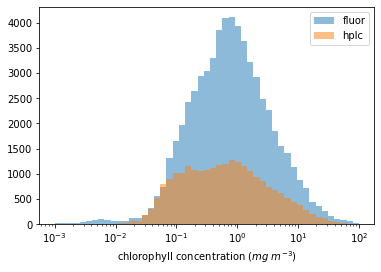

In [23]:
plt.hist(chl_data.chla_fluor, bins=np.logspace(-3,2,50), alpha=.5, label='fluor')
plt.hist(chl_data.chla_hplc, bins=np.logspace(-3,2,50), alpha=.5, label='hplc')
plt.xscale('log')
plt.xlabel('chlorophyll concentration ($mg\ m^{-3}$)')
plt.legend()

Histograms matches figure 7 in Valente et al. (2019) so that's great! However we need to bin the data by geographic area in order to prevent geographic bias in our dataset. 

### Bin data by geographic area
I binned the chlorophyll-a data in 5x5 degree grids (and calculated the mean) as to match figure 10b in Valente et al. (2019)

In [24]:
# bin size 5 deg
step = 5
to_bin = lambda x: np.floor(x / step) * step
# create bins
chl_data['lat_bin'] = chl_data.lat.map(to_bin)
chl_data['lon_bin'] = chl_data.lon.map(to_bin)

In [40]:
# select columns
cols = ['chla_hplc', 'chla_fluor', 'lat_bin', 'lon_bin']
# aggregate data
chl_mean_data = chl_data[cols]\
                            .groupby(cols[-2:])\
                            .mean()
# calculate mean of hplc and fluor measurements
chl_mean_data['chla_mean'] = chl_mean_data.mean(axis=1, skipna=True)

In [41]:
lat = np.arange(-90,90.1,5)
lon = np.arange(-180,180.1,5)

def make_map(lat, lon, data):
    f, ax = plt.subplots(1)
    lon, lat = np.meshgrid(lon,lat)
    
    values = []
    for i,j in zip(lat.flatten(), lon.flatten()):
        try:
            values.append(data.loc[i,j])
        except KeyError:
            values.append(np.nan)
            
    values = np.array(values)
    values = values.reshape(lon.shape)   
    ax.pcolormesh(lon, lat, values)
    
    return f, ax

A rough sketch of the geographic distribution of the average log-transformed chlorophyll-a concentration for all HPLC and fluorometric measurements. Plot seems to agree (qualitatively) with figure 10b in Valente et al. (2019)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11e33a4e0>)

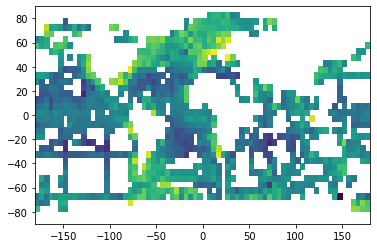

In [42]:
make_map(lat, lon, np.log(chl_mean_data.chla_mean))

Let's look at the distribution now. Uncomment first two lines to see HPLC and fluorometric chlorophyll distribution

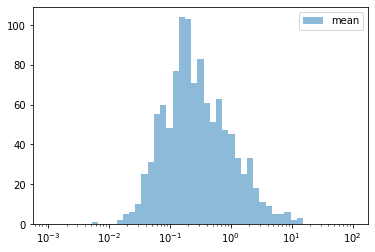

In [35]:
#plt.hist(chl_mean_data.chla_fluor, bins=np.logspace(-3,2,50), alpha=.5, label='fluor')
#plt.hist(chl_mean_data.chla_hplc, bins=np.logspace(-3,2,50), alpha=.5, label='hplc')
plt.hist(chl_mean_data.chla_mean, bins=np.logspace(-3,2,50), alpha=.5, label='mean')
plt.xscale('log')
plt.legend()

Distribution resembles a log-normal distribution. Salama (2012) (http://doi.org/10.5772/27365) used log-normal priors for IOPs:

> The log-normal assumption is based on Campbell’s work (Campbell, 1995) who pointed out that, in general, marine bio-geophysical quantities follow a log-normal distribution i.e. their log transform has a Gaussian distribution.

So I think it would be reasonable to fit a log-normal distribution to our data...

In [38]:
# write chl distribution data to csv
chl_mean_data.to_csv('../data/interim/chla_mean_geo_distr.csv')

### ESA CCI chlorophyll product
I also downloaded ESA CCI chlorophyll products at 4km resolution (monthly averaged) to see how it matches up to the in-situ data. However, file size for a single month is around 150mb so I did not include it in my repository. You can download it here: https://www.oceancolour.org/browser/get.php?date=2018-11-01&product=chlor_a&period=monthly&format=netcdf&mapping=GEO&version=42

In [36]:
chl_cci_data = xr.open_dataset('../data/external/ESA_CCI/ESACCI-OC-L3S-CHLOR_A-MERGED-1M_MONTHLY_4km_GEO_PML_OCx-201811-fv4.2.nc')

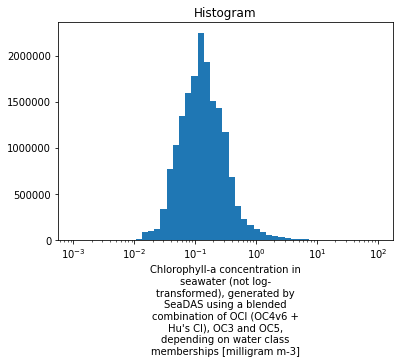

In [37]:
chl_cci_data.chlor_a.plot.hist(bins=np.logspace(-3,2,50))
plt.xscale('log')

## CDOM

Let's use Valente's dataset to map absorption by CDOM and detrital matter

In [189]:
# read IOP/AOP + TSM data
iop_data = pd.read_csv('../data/external/2019_VALENTE_PANGAEA/insitudb_iopskdtsm_2019-06_corrected.csv', low_memory=False)

I aggregate all absorption data between 440 and 443nm to increase the size of our dataset

In [53]:
# select adg absorption for 44x nm
adg_cols = ['adg_440','adg_442','adg_443']

In [54]:
adg_data = iop_data.loc[:][['lat','lon'] + adg_cols]
adg_data['adg_44x'] = adg_data.apply(
    lambda x: np.nanmean(x[adg_cols]), axis=1)

/Users/tadzio/anaconda3/envs/hydropt-4-sent3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [74]:
adg_data['lat_bin'] = adg_data.lat.map(to_bin)
adg_data['lon_bin'] = adg_data.lon.map(to_bin)
adg_data.drop(['lat','lon'], axis=1, inplace=True)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12009b860>)

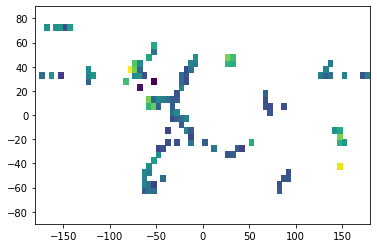

In [80]:
adg_data_mean = adg_data\
                    .groupby(['lat_bin','lon_bin'])\
                    .mean()
make_map(lat, lon, np.log10(adg_data_mean.adg_44x))

The in-situ data on $a_{dg}$ is too sparse. Next I try satellite retrievals of $a_{dg}(443)$

#### ESA CCI $a_{dg}$(443) data

Load ESA CCI $a_{dg}(443)$ data:

In [217]:
# load ESA CCI data on adg for month of April 2016
esa_cci_adg = xr.open_dataset('../data/external/ESA_CCI/2016_04_01_adg_443.nc')

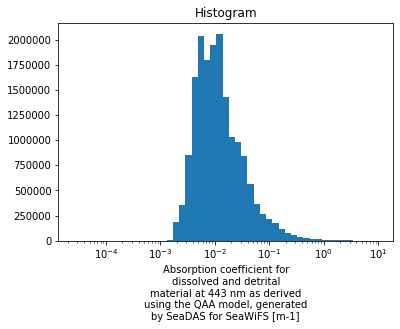

In [230]:
esa_cci_adg.adg_443.plot.hist(bins=np.logspace(
    np.log10(esa_cci_adg.adg_443.min()),
    np.log10(esa_cci_adg.adg_443.max())));
plt.xscale('log')

In [234]:
# convert to pandas
esa_cci_adg = esa_cci_adg.isel(time=0).to_dataframe()

Now bin data in 5 degree grids so it matches resolution of the chlorophyll dataset.

In [238]:
#esa_cci_adg.drop('time', axis=1, inplace=True)
esa_cci_adg.reset_index(inplace=True)
esa_cci_adg['lat_bin'] = esa_cci_adg.lat.map(to_bin)
esa_cci_adg['lon_bin'] = esa_cci_adg.lon.map(to_bin)

In [240]:
esa_cci_adg.drop(['lat','lon'], axis=1, inplace=True)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12d9c9be0>)

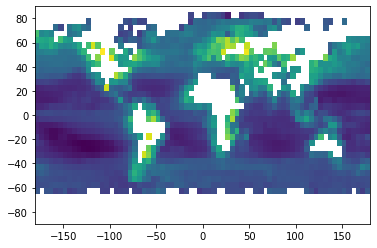

In [241]:
esa_cci_adg = esa_cci_adg\
                    .groupby(['lat_bin','lon_bin'])\
                    .mean()
make_map(lat, lon, np.log10(esa_cci_adg.adg_443))

Text(0.5, 0, 'Absorption coefficient for dissolved and detrial material at 443nm')

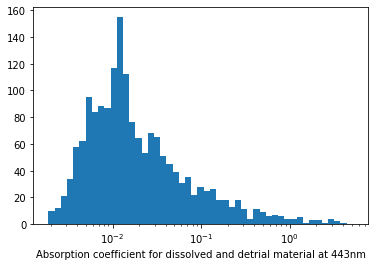

In [245]:
plt.hist(esa_cci_adg.adg_443, bins=np.logspace(
    np.log10(esa_cci_adg.adg_443.min()),
    np.log10(esa_cci_adg.adg_443.max())))
plt.xscale('log')
plt.xlabel('Absorption coefficient for dissolved and detrial material at 443nm')

Now we have $a_{dg}$ data at 5 degree resolution. However the spatial resolution of the data affects the distribution (compare this histrogram with the one above). Lets use this distribution as a prior for now but we need to think about how the spatial resolution of our data affects the prior distribution. Also retrievals and in-situ measurements have a lower detection bound so this also affects the lower end of the distribution. Fruit for thought :) ....

In [246]:
esa_cci_adg.to_csv('../data/interim/adg_mean_geo_distr.csv')

### TSM

In [211]:
tsm_data = iop_data.loc[:][['lat','lon','tsm']]

In [213]:
tsm_data['lat_bin'] = tsm_data.lat.map(to_bin)
tsm_data['lon_bin'] = tsm_data.lon.map(to_bin)
tsm_data.drop(['lat','lon'], axis=1, inplace=True)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12679da90>)

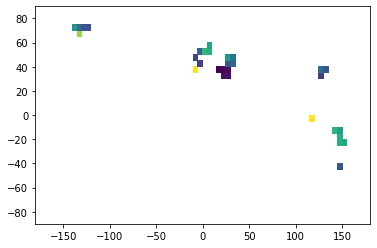

In [215]:
tsm_data_mean = tsm_data\
                    .groupby(['lat_bin','lon_bin'])\
                    .mean()
make_map(lat, lon, np.log10(tsm_data_mean.tsm))

Data on TSM is too sparse to use. Need to find another solution here... Unfortunately ESA CCI does not provide TSM retrievals.